# Случайный лес на языке R
## Построение с помощью пакета randomForest

### Подготовка данных

Загружаем и смотрим данные. Помечаем пустые строковые значения как пропуски. 

In [82]:
data <- read.csv2("./credit.csv", colClasses = "character", na.strings="")

In [83]:
print(str(data))
head(data)

'data.frame':	170746 obs. of  15 variables:
 $ client_id           : chr  "1" "2" "3" "4" ...
 $ gender              : chr  "M" "F" "M" "F" ...
 $ age                 : chr  "48.0" "28.0" "32.0" "27.0" ...
 $ marital_status      : chr  "MAR" "MAR" "MAR" "DIV" ...
 $ job_position        : chr  "UMN" "UMN" "SPC" "SPC" ...
 $ credit_sum          : chr  "59998" "10889" "10728" "12009,09" ...
 $ credit_month        : chr  "10" "6" "12" "12" ...
 $ tariff_id           : chr  "28" "2" "2" "2" ...
 $ score_shk           : chr  "0,770249" "0,248514" "0,459589" "0,362536" ...
 $ education           : chr  "GRD" "GRD" "SCH" "GRD" ...
 $ living_region       : chr  "КРАСНОДАРСКИЙ КРАЙ" "МОСКВА" "САРАТОВСКАЯ ОБЛАСТЬ" "ВОЛГОГРАДСКАЯ ОБЛАСТЬ" ...
 $ monthly_income      : chr  "30000.0" "43000.0" "23000.0" "17000.0" ...
 $ credit_count        : chr  "1.0" "2.0" "5.0" "2.0" ...
 $ overdue_credit_count: chr  "1.0" "0.0" "0.0" "0.0" ...
 $ open_account_flg    : chr  "0" "0" "0" "0" ...
NULL


client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
1,M,48.0,MAR,UMN,59998,10,28,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,28.0,MAR,UMN,10889,6,2,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
3,M,32.0,MAR,SPC,10728,12,2,"0,459589",SCH,САРАТОВСКАЯ ОБЛАСТЬ,23000.0,5.0,0.0,0
4,F,27.0,DIV,SPC,"12009,09",12,2,"0,362536",GRD,ВОЛГОГРАДСКАЯ ОБЛАСТЬ,17000.0,2.0,0.0,0
5,M,45.0,MAR,SPC,"16908,89",10,2,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0
6,F,37.0,MAR,SPC,26788,10,2,"0,484203",SCH,СТАВРОПОЛЬСКИЙ КРАЙ,30000.0,0.0,0.0,0


In [84]:
print(paste('Всего строк с пропусками:', sum(is.na(data))))
#data[!complete.cases(data),]

[1] "Всего строк с пропусками: 18664"


Подготавливаем данные

In [85]:
# Удаляем колонку data$client_id как не имеющую ценности для модели
data$client_id <- NULL

In [86]:
# смотрим дублирующиеся наблюдения
nrow(data[duplicated(data),])

[1] 1151

In [87]:
# оставим только уникальные наблюдения  
data <- unique(data)
# смотрим, сколько наблюдений мы
# теперь будем использовать  
nrow(data)

[1] 169595

In [88]:
data$age <- as.integer(data$age)
data$credit_sum <- gsub(',', ".", data$credit_sum)
data$credit_sum <- as.numeric(data$credit_sum)
data$credit_month <- as.integer(data$credit_month)
data$score_shk <- gsub(',', ".", data$score_shk)
data$score_shk <- as.numeric(data$score_shk)
data$monthly_income <- as.numeric(data$monthly_income)
data$credit_count <- as.integer(data$credit_count)
data$overdue_credit_count <- as.integer(data$overdue_credit_count)
data$open_account_flg <- as.integer(data$open_account_flg)
str(data)

'data.frame':	169595 obs. of  14 variables:
 $ gender              : chr  "M" "F" "M" "F" ...
 $ age                 : int  48 28 32 27 45 37 NA 26 23 32 ...
 $ marital_status      : chr  "MAR" "MAR" "MAR" "DIV" ...
 $ job_position        : chr  "UMN" "UMN" "SPC" "SPC" ...
 $ credit_sum          : num  59998 10889 10728 12009 16909 ...
 $ credit_month        : int  10 6 12 12 10 10 6 10 12 10 ...
 $ tariff_id           : chr  "28" "2" "2" "2" ...
 $ score_shk           : num  0.77 0.249 0.46 0.363 0.421 ...
 $ education           : chr  "GRD" "GRD" "SCH" "GRD" ...
 $ living_region       : chr  "КРАСНОДАРСКИЙ КРАЙ" "МОСКВА" "САРАТОВСКАЯ ОБЛАСТЬ" "ВОЛГОГРАДСКАЯ ОБЛАСТЬ" ...
 $ monthly_income      : num  30000 43000 23000 17000 25000 30000 28000 60000 50000 39500 ...
 $ credit_count        : int  1 2 5 2 1 0 3 3 3 7 ...
 $ overdue_credit_count: int  1 0 0 0 0 0 0 0 0 0 ...
 $ open_account_flg    : int  0 0 0 0 0 0 0 0 0 0 ...


Разбиваем данные на обучающую и контрольную выборки

In [89]:
set.seed(42)
data$random_number <- runif(nrow(data),0,1)
development <- data[which(data$random_number > 0.3), ]
holdout <- data[ which(data$random_number <= 0.3), ]
development$random_number <- NULL
holdout$random_number <- NULL
data$random_number <- NULL

Смотрим обучающую и контрольную выборки

In [90]:
str(development)

'data.frame':	118711 obs. of  14 variables:
 $ gender              : chr  "M" "F" "F" "M" ...
 $ age                 : int  48 28 27 45 37 NA 23 32 26 26 ...
 $ marital_status      : chr  "MAR" "MAR" "DIV" "MAR" ...
 $ job_position        : chr  "UMN" "UMN" "SPC" "SPC" ...
 $ credit_sum          : num  59998 10889 12009 16909 26788 ...
 $ credit_month        : int  10 6 12 10 10 6 12 10 14 10 ...
 $ tariff_id           : chr  "28" "2" "2" "2" ...
 $ score_shk           : num  0.77 0.249 0.363 0.421 0.484 ...
 $ education           : chr  "GRD" "GRD" "GRD" "SCH" ...
 $ living_region       : chr  "КРАСНОДАРСКИЙ КРАЙ" "МОСКВА" "ВОЛГОГРАДСКАЯ ОБЛАСТЬ" "ЧЕЛЯБИНСКАЯ ОБЛАСТЬ" ...
 $ monthly_income      : num  30000 43000 17000 25000 30000 28000 50000 39500 36000 30000 ...
 $ credit_count        : int  1 2 2 1 0 3 3 7 2 0 ...
 $ overdue_credit_count: int  1 0 0 0 0 0 0 0 0 0 ...
 $ open_account_flg    : int  0 0 0 0 0 0 0 0 0 0 ...


In [91]:
str(holdout)

'data.frame':	50884 obs. of  14 variables:
 $ gender              : chr  "M" "F" "M" "F" ...
 $ age                 : int  32 26 43 54 40 26 44 64 28 32 ...
 $ marital_status      : chr  "MAR" "UNM" "MAR" "UNM" ...
 $ job_position        : chr  "SPC" "SPC" "INP" "UMN" ...
 $ credit_sum          : num  10728 47878 57567 24990 18890 ...
 $ credit_month        : int  12 10 10 12 6 10 18 10 10 10 ...
 $ tariff_id           : chr  "2" "2" "2" "2" ...
 $ score_shk           : num  0.46 0.513 0.341 0.414 0.299 ...
 $ education           : chr  "SCH" "GRD" "GRD" "GRD" ...
 $ living_region       : chr  "САРАТОВСКАЯ ОБЛАСТЬ" "МОСКОВСКАЯ ОБЛАСТЬ" "ТЮМЕНСКАЯ ОБЛАСТЬ" "ТЮМЕНСКАЯ ОБЛАСТЬ" ...
 $ monthly_income      : num  23000 60000 60000 40000 45000 30000 18400 29000 40000 30000 ...
 $ credit_count        : int  5 3 7 6 5 4 3 3 1 2 ...
 $ overdue_credit_count: int  0 0 0 0 0 0 0 0 0 0 ...
 $ open_account_flg    : int  0 0 0 1 1 0 0 0 0 0 ...


импутация пропусков

In [92]:
library(imputeMissings)
# С помощью функции colSums пакета imputeMissings выводим сводку по пропускам
colSums(is.na(development))

# Вычисляем с помощью функции compute пакета imputeMissings медианы для количественных
# переменных и моды для категориальных переменных
values <- compute(development)
values

gender                  age       marital_status 
                   0                    2                    2 
        job_position           credit_sum         credit_month 
                   0                    1                    0 
           tariff_id            score_shk            education 
                   0                    3                    3 
       living_region       monthly_income         credit_count 
                 139                    1                 6463 
overdue_credit_count     open_account_flg 
                6463                    0

$gender
[1] "F"

$age
[1] 34

$marital_status
[1] "MAR"

$job_position
[1] "SPC"

$credit_sum
[1] 21269

$credit_month
[1] 10

$tariff_id
[1] "2"

$score_shk
[1] 0.461799

$education
[1] "SCH"

$living_region
[1] "МОСКОВСКАЯ ОБЛАСТЬ"

$monthly_income
[1] 35000

$credit_count
[1] 2

$overdue_credit_count
[1] 0

$open_account_flg
[1] 0

In [93]:
# Загружаем пакет imputeTS
library(imputeTS)

# Выполняем импутацию модами и медианами
development$age <- na.replace(development$age, fill = 34)
development$marital_status <- ifelse(is.na(development$marital_status), 'MAR', development$marital_status)
development$credit_sum <- na.replace(development$credit_sum, fill = 21269)
development$score_shk <- na.replace(development$score_shk, fill = 0.461799)
development$education <- ifelse(is.na(development$education), 'SCH', development$education)

# Пропущенные значения living_region заполняем значением 'НЕ УКАЗАН' (создаем отдельную категорию для пропусков)
development$living_region <- ifelse(is.na(development$living_region), 'НЕ УКАЗАН', development$living_region)

# credit_count и overdue_credit_count заполняем значением 999
development$credit_count <- na.replace(development$credit_count, fill = 999999999)
development$overdue_credit_count <- na.replace(development$overdue_credit_count, fill = 999999999)

# Пропущенные значения среднего дохода в идеале нужно пытаться восстанавливать с учетом разделения в России дохода
# по полу и регионам.
# Но в данной тестовой выборке только 1 пропущенное значение из 6556 строк, а в контрольной - вообще нет таких значений. 
# Поэтому просто заменим средним по выборке.
development$monthly_income <- na.replace(development$monthly_income, fill = 35000)

# выводим сводку по пропускам
colSums(is.na(development))

gender                  age       marital_status 
                   0                    0                    0 
        job_position           credit_sum         credit_month 
                   0                    0                    0 
           tariff_id            score_shk            education 
                   0                    0                    0 
       living_region       monthly_income         credit_count 
                   0                    0                    0 
overdue_credit_count     open_account_flg 
                   0                    0

Повторяем для контрольной выборки

In [94]:
# выводим сводку по пропускам
colSums(is.na(holdout))

# Вычисляем медианы для количественных переменных и моды для категориальных переменных
values <- compute(holdout)
values

gender                  age       marital_status 
                   0                    0                    0 
        job_position           credit_sum         credit_month 
                   0                    0                    0 
           tariff_id            score_shk            education 
                   0                    0                    0 
       living_region       monthly_income         credit_count 
                  50                    0                 2727 
overdue_credit_count     open_account_flg 
                2727                    0

$gender
[1] "F"

$age
[1] 35

$marital_status
[1] "MAR"

$job_position
[1] "SPC"

$credit_sum
[1] 21119

$credit_month
[1] 10

$tariff_id
[1] "2"

$score_shk
[1] 0.460917

$education
[1] "SCH"

$living_region
[1] "МОСКОВСКАЯ ОБЛАСТЬ"

$monthly_income
[1] 35000

$credit_count
[1] 2

$overdue_credit_count
[1] 0

$open_account_flg
[1] 0

In [95]:
# Пропущенные значения living_region заполняем значением 'НЕ УКАЗАН' (создаем отдельную категорию для пропусков)
holdout$living_region <- ifelse(is.na(holdout$living_region), 'НЕ УКАЗАН', holdout$living_region)

# credit_count и overdue_credit_count заполняем значением 999999999
holdout$credit_count <- na.replace(holdout$credit_count, fill = 999999999)
holdout$overdue_credit_count <- na.replace(holdout$overdue_credit_count, fill = 999999999)

# выводим сводку по пропускам
colSums(is.na(holdout))

# выгружаем пакеты
detach("package:imputeMissings", unload=TRUE)
detach("package:imputeTS", unload=TRUE)

gender                  age       marital_status 
                   0                    0                    0 
        job_position           credit_sum         credit_month 
                   0                    0                    0 
           tariff_id            score_shk            education 
                   0                    0                    0 
       living_region       monthly_income         credit_count 
                   0                    0                    0 
overdue_credit_count     open_account_flg 
                   0                    0

In [96]:
# Загружаем пакет Hmisc и с помощью функции describe этого пакета 
# выводим подробную информацию о переменных
library(Hmisc)

describe(development)
describe(holdout)

detach("package:Hmisc", unload=TRUE)


Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units



development 

 14  Variables      118711  Observations
--------------------------------------------------------------------------------
gender 
       n  missing distinct 
  118711        0        2 
                      
Value          F     M
Frequency  61783 56928
Proportion  0.52  0.48
--------------------------------------------------------------------------------
age 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
  118711        0       54    0.999    36.49    11.79       23       24 
     .25      .50      .75      .90      .95 
      28       34       43       52       57 

lowest : 18 19 20 21 22, highest: 67 68 69 70 71
--------------------------------------------------------------------------------
marital_status 
       n  missing distinct 
  118711        0        5 
                                        
Value        CIV   DIV   MAR   UNM   WID
Frequency   2883 11754 65252 36382  2440
Proportion 0.024 0.099 0.550 0.306 0.021
-----------------

holdout 

 14  Variables      50884  Observations
--------------------------------------------------------------------------------
gender 
       n  missing distinct 
   50884        0        2 
                      
Value          F     M
Frequency  26314 24570
Proportion 0.517 0.483
--------------------------------------------------------------------------------
age 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   50884        0       54    0.999    36.53    11.76       23       25 
     .25      .50      .75      .90      .95 
      28       35       43       52       57 

lowest : 18 19 20 21 22, highest: 67 68 69 70 71
--------------------------------------------------------------------------------
marital_status 
       n  missing distinct 
   50884        0        5 
                                        
Value        CIV   DIV   MAR   UNM   WID
Frequency   1284  5082 28061 15445  1012
Proportion 0.025 0.100 0.551 0.304 0.020
----------------------

Преобразуем типы данных

In [97]:
development$gender <- as.factor(development$gender)
development$education <- as.factor(development$education)
# development$credit_count <- ordered(development$credit_count, 
#                          levels = c(min(development$credit_count) : max(development$credit_count)))
# development$overdue_credit_count <- ordered(development$overdue_credit_count, 
#                          levels = c(min(development$overdue_credit_count) : max(development$overdue_credit_count)))
development$credit_count <- as.factor(paste0("credit_count", development$credit_count))
development$overdue_credit_count <- as.factor(paste0("overdue_credit_count",development$overdue_credit_count))
str(development)

'data.frame':	118711 obs. of  14 variables:
 $ gender              : Factor w/ 2 levels "F","M": 2 1 1 2 1 2 2 1 2 1 ...
 $ age                 : num  48 28 27 45 37 34 23 32 26 26 ...
 $ marital_status      : chr  "MAR" "MAR" "DIV" "MAR" ...
 $ job_position        : chr  "UMN" "UMN" "SPC" "SPC" ...
 $ credit_sum          : num  59998 10889 12009 16909 26788 ...
 $ credit_month        : int  10 6 12 10 10 6 12 10 14 10 ...
 $ tariff_id           : chr  "28" "2" "2" "2" ...
 $ score_shk           : num  0.77 0.249 0.363 0.421 0.484 ...
 $ education           : Factor w/ 5 levels "ACD","GRD","PGR",..: 2 2 2 4 4 4 4 2 4 2 ...
 $ living_region       : chr  "КРАСНОДАРСКИЙ КРАЙ" "МОСКВА" "ВОЛГОГРАДСКАЯ ОБЛАСТЬ" "ЧЕЛЯБИНСКАЯ ОБЛАСТЬ" ...
 $ monthly_income      : num  30000 43000 17000 25000 30000 28000 50000 39500 36000 30000 ...
 $ credit_count        : Factor w/ 22 levels "credit_count0",..: 2 13 13 2 1 15 15 19 13 1 ...
 $ overdue_credit_count: Factor w/ 5 levels "overdue_credit_count0",..

In [101]:
holdout$gender <- as.factor(holdout$gender)
holdout$education <- as.factor(holdout$education)
# holdout$credit_count <- ordered(holdout$credit_count, 
#                          levels = c(min(holdout$credit_count) : max(holdout$credit_count)))
# holdout$overdue_credit_count <- ordered(holdout$overdue_credit_count, 
#                          levels = c(min(holdout$overdue_credit_count) : max(holdout$overdue_credit_count)))
holdout$credit_count <- as.factor(paste0("credit_count", holdout$credit_count))
holdout$overdue_credit_count <- as.factor(paste0("overdue_credit_count", holdout$overdue_credit_count))
str(holdout)

'data.frame':	50884 obs. of  14 variables:
 $ gender              : Factor w/ 2 levels "F","M": 2 1 2 1 2 1 2 1 2 1 ...
 $ age                 : int  32 26 43 54 40 26 44 64 28 32 ...
 $ marital_status      : chr  "MAR" "UNM" "MAR" "UNM" ...
 $ job_position        : chr  "SPC" "SPC" "INP" "UMN" ...
 $ credit_sum          : num  10728 47878 57567 24990 18890 ...
 $ credit_month        : int  12 10 10 12 6 10 18 10 10 10 ...
 $ tariff_id           : chr  "2" "2" "2" "2" ...
 $ score_shk           : num  0.46 0.513 0.341 0.414 0.299 ...
 $ education           : Factor w/ 5 levels "ACD","GRD","PGR",..: 4 2 2 2 2 2 4 4 4 2 ...
 $ living_region       : chr  "САРАТОВСКАЯ ОБЛАСТЬ" "МОСКОВСКАЯ ОБЛАСТЬ" "ТЮМЕНСКАЯ ОБЛАСТЬ" "ТЮМЕНСКАЯ ОБЛАСТЬ" ...
 $ monthly_income      : num  23000 60000 60000 40000 45000 30000 18400 29000 40000 30000 ...
 $ credit_count        : Factor w/ 20 levels "credit_count0",..: 15 13 17 16 15 14 13 13 2 12 ...
 $ overdue_credit_count: Factor w/ 5 levels "overdue_credit_c

In [102]:
# выводим информацию о распределении
# классов зависимой переменной response
# в обучающей выборке
summary(development$open_account_flg)

# выводим информацию о распределении
# классов зависимой переменной response
# в контрольной выборке
summary(holdout$open_account_flg)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1763  0.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1795  0.0000  1.0000 

Копируем данные

In [103]:
copy_dev <- development
copy_hold <- holdout
# Записываем в отдельные CSV файлы.
write.csv(copy_dev, "copy_dev.csv")
write.csv(copy_hold, "copy_hold.csv")

### Обрабатываем признаки

In [1]:
# Контрольная точка - загружаем данные
copy_dev <- read.csv("./copy_dev.csv")
copy_hold <- read.csv("./copy_hold.csv")

In [2]:
copy_dev$X <- NULL
copy_hold$X <- NULL

copy_dev$credit_count <- as.factor(copy_dev$credit_count)
copy_dev$overdue_credit_count <- as.factor(copy_dev$overdue_credit_count)

copy_hold$credit_count <- as.factor(copy_hold$credit_count)
copy_hold$overdue_credit_count <- as.factor(copy_hold$overdue_credit_count)

str(copy_dev)
str(copy_hold)

'data.frame':	118711 obs. of  14 variables:
 $ gender              : Factor w/ 2 levels "F","M": 2 1 1 2 1 2 2 1 2 1 ...
 $ age                 : int  48 28 27 45 37 34 23 32 26 26 ...
 $ marital_status      : Factor w/ 5 levels "CIV","DIV","MAR",..: 3 3 2 3 3 3 3 4 3 4 ...
 $ job_position        : Factor w/ 18 levels "ATP","BIS","BIU",..: 15 15 14 14 14 14 14 14 14 14 ...
 $ credit_sum          : num  59998 10889 12009 16909 26788 ...
 $ credit_month        : int  10 6 12 10 10 6 12 10 14 10 ...
 $ tariff_id           : int  28 2 2 2 2 25 28 2 1 19 ...
 $ score_shk           : num  0.77 0.249 0.363 0.421 0.484 ...
 $ education           : Factor w/ 5 levels "ACD","GRD","PGR",..: 2 2 2 4 4 4 4 2 4 2 ...
 $ living_region       : Factor w/ 82 levels "АЛТАЙСКИЙ КРАЙ",..: 23 30 8 77 68 34 73 68 63 46 ...
 $ monthly_income      : num  30000 43000 17000 25000 30000 28000 50000 39500 36000 30000 ...
 $ credit_count        : Factor w/ 22 levels "credit_count0",..: 2 13 13 2 1 15 15 19 13 1 ...

### living_region

Здесь посложнее. 82 категории в дерево не влезут. Получим ошибку:
Error in randomForest.default(m, y, ...) : Can not handle categorical predictors with more than 53 categories.

Заменим категориальную переменную на количественную, используя сглаженное среднее значение целевой переменной по выборке для каждого значения категории. C помощью подбора округления сократим количество различных значений, а затем закодируем новую фичу как категорию.

new_f = (mean(target)*nrows + global_mean*alpha) / (nrows + alpha)

Где 
- mean(target) - среднее значение целевой переменной для данной категории
- nrows - количество наблюдений для данной категории
- global_mean - среднее значение целевой переменной по всей выборке
- alpha - коэффициент регуляризации

Если наблюдений для данной категории "мало", то получаем некое среднее значение таргета по выборке.
Если наблюдений для данной категории "много", то получаем среднее значение таргета по данной категории в выборке.

Коэффициент регуляризации подбирается при тюнинге модели.

In [3]:
alpha <- 2400 # 5% от выборки
global_mean_dev <- 0.1763 # по тестовой выборке

un_values <- unique(copy_dev$living_region, incomparables = FALSE)

copy_dev$living_reg_SL <- rep(0, nrow(copy_dev))
copy_hold$living_reg_SL <- rep(0, nrow(copy_hold))

for (x in un_values){
    cur_mean_target <- mean(copy_dev[copy_dev$living_region == x, ]$open_account_flg)
    cur_nrows <- nrow(copy_dev[copy_dev$living_region == x, ])
    cur_living_reg_SL <- round((cur_mean_target*cur_nrows + global_mean_dev*alpha) / (cur_nrows + alpha), 3) 
    copy_dev$living_reg_SL[copy_dev$living_region == x] <- rep(cur_living_reg_SL, cur_nrows)
    
    cur_nrows <- nrow(copy_hold[copy_hold$living_region == x, ])
    copy_hold$living_reg_SL[copy_hold$living_region == x] <- rep(cur_living_reg_SL, cur_nrows)
#     print(paste(x, cur_living_reg_SL))
}
print(paste("Уникальных значений в тестовой выборке:", length(unique(copy_dev$living_reg_SL, incomparables = FALSE))))
print(paste("Уникальных значений в контрольной выборке:", length(unique(copy_hold$living_reg_SL, incomparables = FALSE))))

[1] "Уникальных значений в тестовой выборке: 35"
[1] "Уникальных значений в контрольной выборке: 35"


In [4]:
copy_dev$marital_status <- as.factor(copy_dev$marital_status)
copy_hold$marital_status <- as.factor(copy_hold$marital_status)

copy_dev$job_position <- as.factor(copy_dev$job_position)
copy_hold$job_position <- as.factor(copy_hold$job_position)

copy_dev$tariff_id <- as.factor(copy_dev$tariff_id)
copy_hold$tariff_id <- as.factor(copy_hold$tariff_id)

copy_dev$living_region <- copy_dev$living_reg_SL
copy_dev$living_region <- as.factor(copy_dev$living_region)

copy_hold$living_region <- copy_hold$living_reg_SL
copy_hold$living_region <- as.factor(copy_hold$living_region)

copy_dev$living_reg_SL <- NULL
copy_hold$living_reg_SL <- NULL

copy_dev$open_account_flg <- as.factor(paste0("open_account_flg_", copy_dev$open_account_flg))
copy_hold$open_account_flg <- as.factor(paste0("open_account_flg_", copy_hold$open_account_flg))

### Предотвращение ошибки Type of predictors in new data do not match that of the training data.

https://stackoverflow.com/questions/24829674/r-random-forest-error-type-of-predictors-in-new-data-do-not-match

In [5]:
common <- intersect(names(copy_dev), names(copy_hold)) 
for (p in common) { 
  if (class(copy_dev[[p]]) == "factor") { 
    levels(copy_hold[[p]]) <- levels(copy_dev[[p]]) 
  } 
}

In [6]:
str(copy_dev)
str(copy_hold)

'data.frame':	118711 obs. of  14 variables:
 $ gender              : Factor w/ 2 levels "F","M": 2 1 1 2 1 2 2 1 2 1 ...
 $ age                 : int  48 28 27 45 37 34 23 32 26 26 ...
 $ marital_status      : Factor w/ 5 levels "CIV","DIV","MAR",..: 3 3 2 3 3 3 3 4 3 4 ...
 $ job_position        : Factor w/ 18 levels "ATP","BIS","BIU",..: 15 15 14 14 14 14 14 14 14 14 ...
 $ credit_sum          : num  59998 10889 12009 16909 26788 ...
 $ credit_month        : int  10 6 12 10 10 6 12 10 14 10 ...
 $ tariff_id           : Factor w/ 33 levels "1","2","3","4",..: 28 2 2 2 2 25 28 2 1 19 ...
 $ score_shk           : num  0.77 0.249 0.363 0.421 0.484 ...
 $ education           : Factor w/ 5 levels "ACD","GRD","PGR",..: 2 2 2 4 4 4 4 2 4 2 ...
 $ living_region       : Factor w/ 35 levels "0.133","0.134",..: 31 34 15 23 1 16 32 1 5 4 ...
 $ monthly_income      : num  30000 43000 17000 25000 30000 28000 50000 39500 36000 30000 ...
 $ credit_count        : Factor w/ 22 levels "credit_count0",..

### Построение модели и получение OOB оценки качества

In [7]:
starttimer <- Sys.time()

library(randomForest)
library(doParallel)
CPUS=20; NTREE=500
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf1 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev, importance=TRUE, ntree=ntree)
}
stopCluster(cl)

# model <- combine(rf.list)

endtimer <- Sys.time()
print(endtimer - starttimer)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Time difference of 41.24927 secs


In [ ]:
# starttimer <- Sys.time()
# library(randomForest)
# model = randomForest(open_account_flg~., data=copy_dev, importance=TRUE)
# endtimer <- Sys.time()
# print(endtimer - starttimer)

In [8]:
table(copy_dev$open_account_flg, predict(rf1))
print(rf1)

                    
                     open_account_flg_0 open_account_flg_1
  open_account_flg_0              97681                106
  open_account_flg_1              20792                132


Call:
 randomForest(formula = open_account_flg ~ ., data = copy_dev,      importance = TRUE, ntree = ntree) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3



Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var




Call:
roc.default(response = copy_dev$open_account_flg, predictor = prob[,     2], ci = TRUE)

Data: prob[, 2] in 97787 controls (copy_dev$open_account_flg open_account_flg_0) < 20924 cases (copy_dev$open_account_flg open_account_flg_1).
Area under the curve: 0.674
95% CI: 0.6701-0.6779 (DeLong)


Call:
roc.default(response = copy_hold$open_account_flg, predictor = prob2[,     2], ci = TRUE)

Data: prob2[, 2] in 41752 controls (copy_hold$open_account_flg open_account_flg_0) < 9132 cases (copy_hold$open_account_flg open_account_flg_1).
Area under the curve: 0.5916
95% CI: 0.5852-0.598 (DeLong)

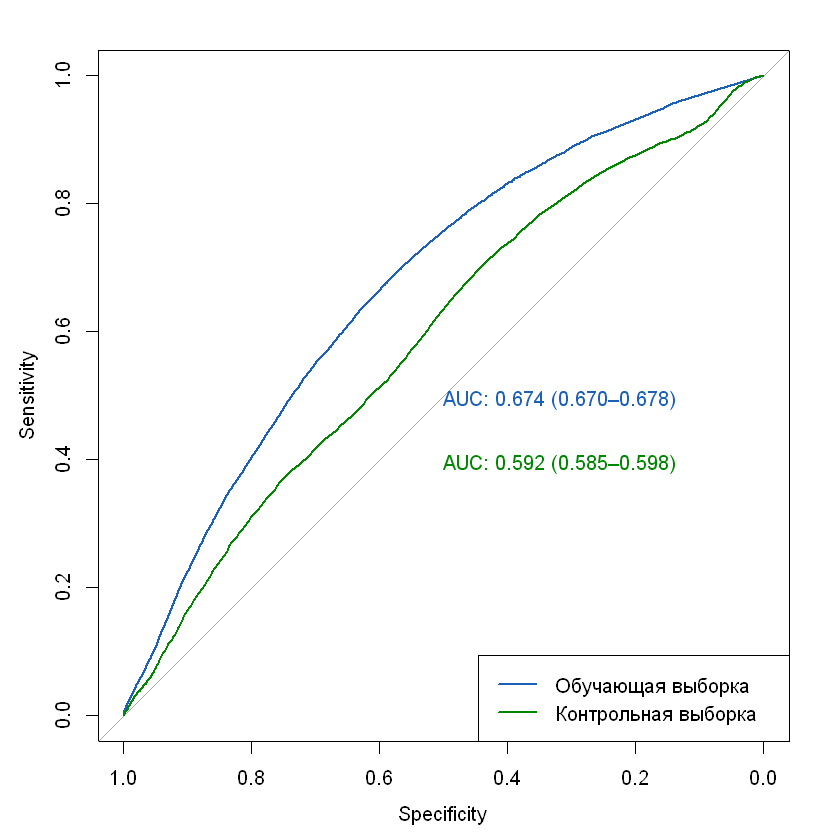

In [9]:
# Загружаем пакет для построения ROC-кривых.
library(pROC)

# Вычисление вероятностей классов

prob <- predict(rf1, type="prob")
prob2 <- predict(rf1, copy_hold, type="prob")

roc(copy_dev$open_account_flg, prob[,2], ci=TRUE)
roc(copy_hold$open_account_flg, prob2[,2], ci=TRUE)

# Строим ROC-кривые.
roc_dev<-plot(roc(copy_dev$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

## Тюнинг модели

0.0001434926 0.05 
-0.003156837 0.05 


,mtry,OOBError
2.OOB,2,0.1760915
3.OOB,3,0.1761168
6.OOB,6,0.1766728


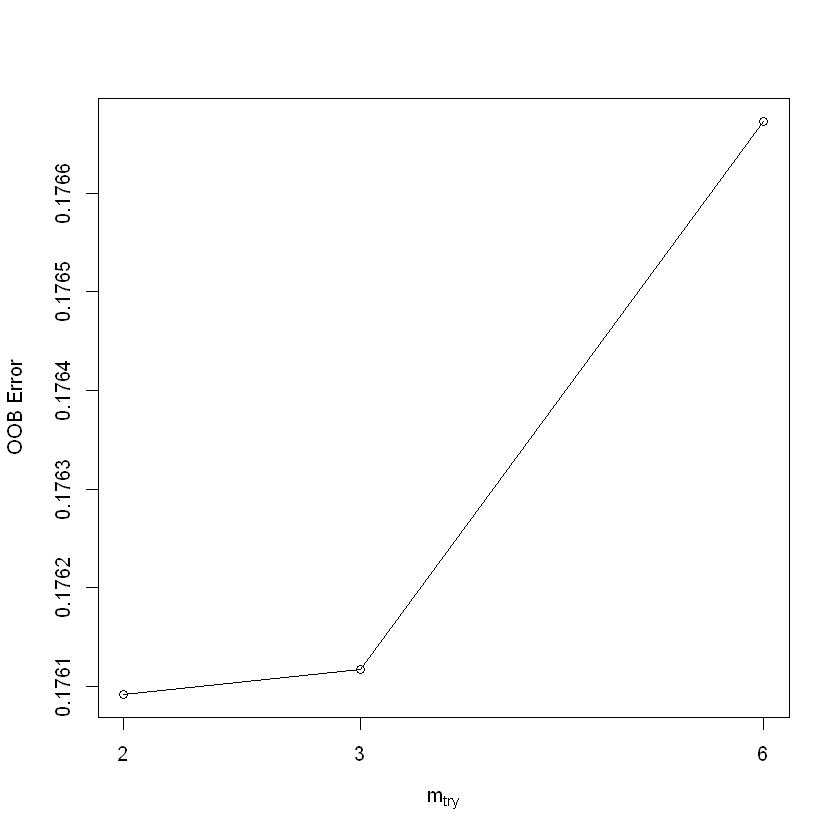

In [48]:
set.seed(152)
tuneRF(copy_dev[,1:13], copy_dev[,14], ntreeTry=500, trace=FALSE)

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



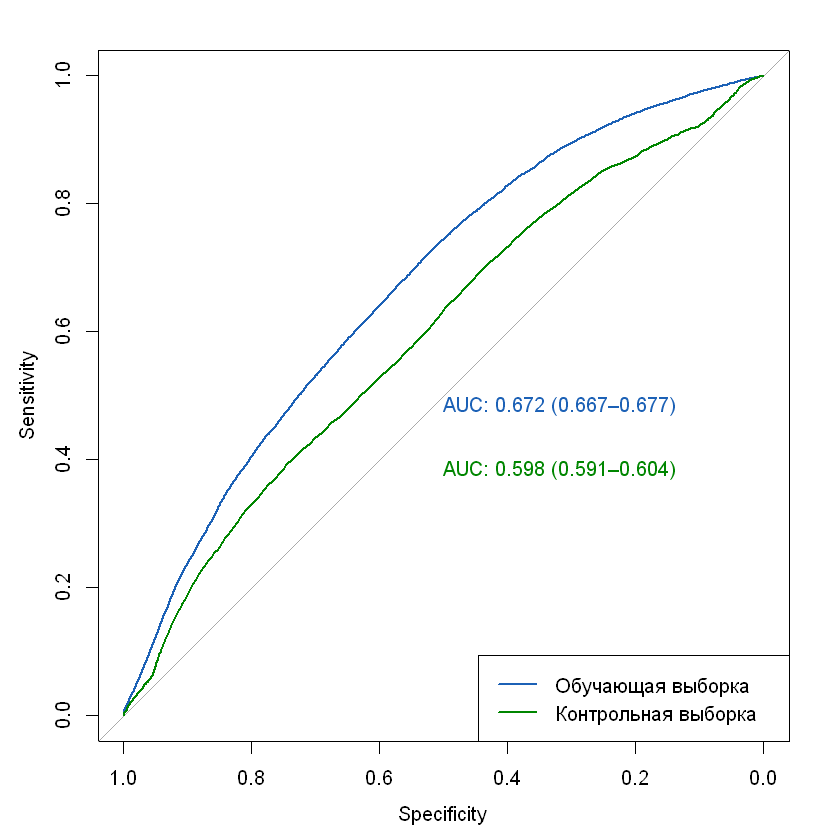

In [10]:
library(caret)
# Попробуем downsample
balanced_dev_down <- downSample(copy_dev[, c(1:13)], copy_dev[,"open_account_flg"], list=FALSE, "open_account_flg")
library(randomForest)
library(doParallel)
CPUS=20; NTREE=500
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf2 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=balanced_dev_down, importance=FALSE, ntree=ntree, mtry=2)
}
stopCluster(cl)

# Вычисление вероятностей классов
library(pROC)
prob <- predict(rf2, type="prob")
prob2 <- predict(rf2, copy_hold, type="prob")

# Строим ROC-кривые.
roc_dev<-plot(roc(balanced_dev_down$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

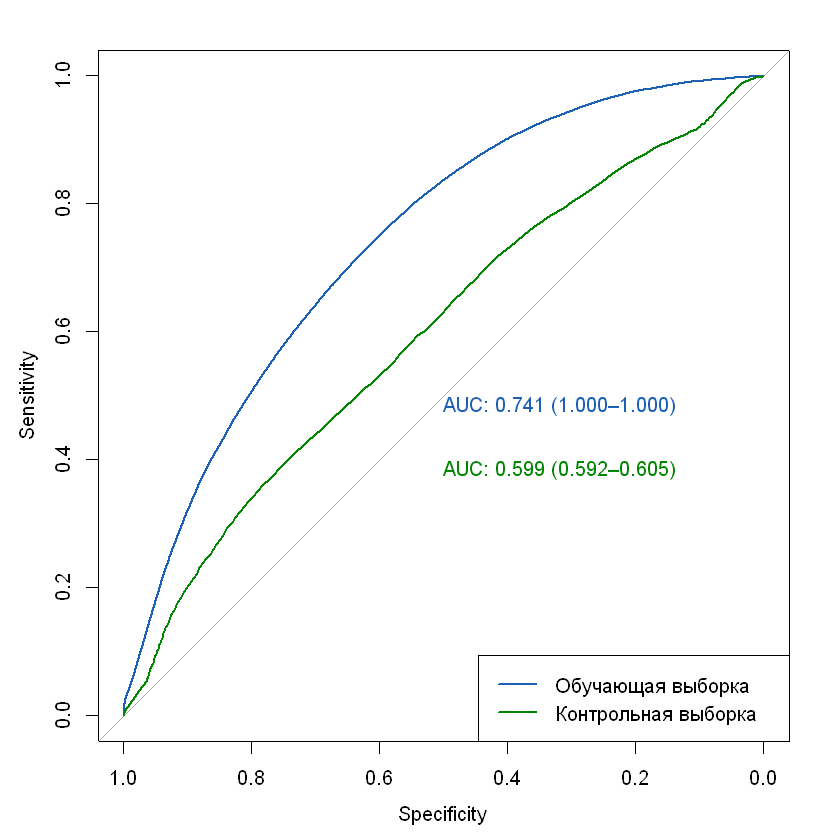

In [11]:
# Попробуем upsample
library(caret)
balanced_dev_up <- upSample(copy_dev[, c(1:13)], copy_dev[,"open_account_flg"], list=FALSE, "open_account_flg")
library(randomForest)
library(doParallel)
CPUS=20; NTREE=500
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf3 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=balanced_dev_up, importance=FALSE, ntree=ntree, mtry=2)
}
stopCluster(cl)

# Вычисление вероятностей классов
library(pROC)
prob <- predict(rf3, type="prob")
prob2 <- predict(rf3, copy_hold, type="prob")

# Строим ROC-кривые.
roc_dev<-plot(roc(balanced_dev_up$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

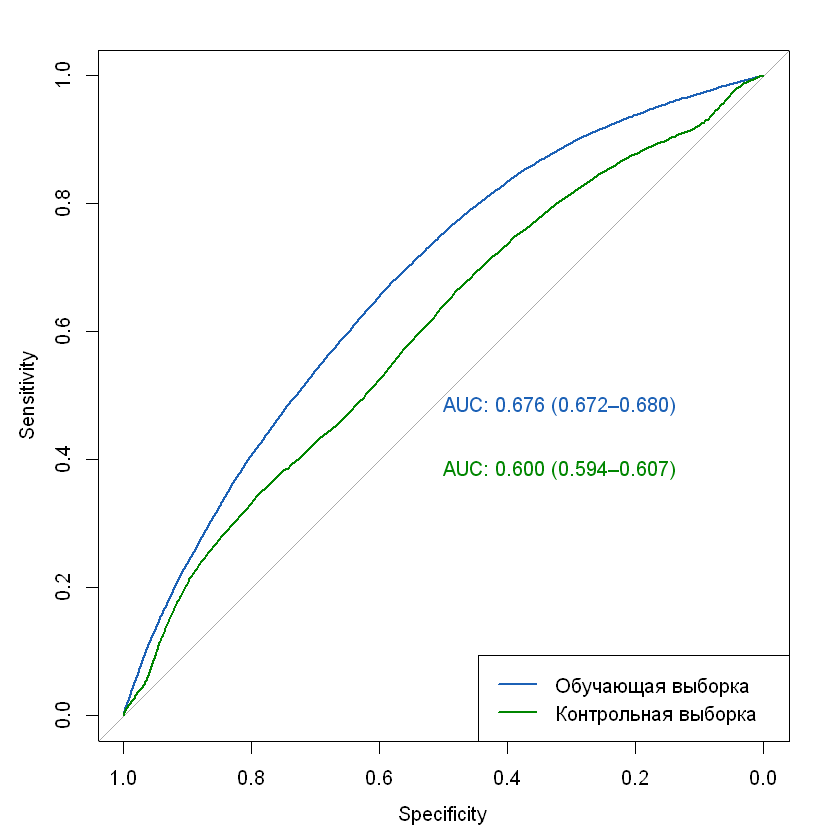

In [33]:
# Попробуем уровнять баланс классов при обучении за счет весов классов и увеличим количество деревьев
library(randomForest)
library(doParallel)
CPUS=20; NTREE=800
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf4 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev, importance=FALSE, ntree=ntree, mtry=2, 
               classwt=c(0.60, 0.4))
}
stopCluster(cl)

# Вычисление вероятностей классов
prob <- predict(rf4, type="prob")
prob2 <- predict(rf4, copy_hold, type="prob")

# Строим ROC-кривые.
library(pROC)
roc_dev<-plot(roc(copy_dev$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

### Попробуем генерацию признаков 

age

In [34]:
copy_dev2 <- copy_dev
copy_hold2 <- copy_hold

# с помощью функции quantileCut пакета lsr разбиваем переменную age на 8 интервалов c одинаковым количеством наблюдений
library(lsr)
copy_dev2$binned <- quantileCut(x=copy_dev2$age, n=8, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

copy_hold2$binned <- quantileCut(x=copy_hold2$age, n=8, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

# смотрим распределение значений
# переменной binned
print(summary(copy_dev2$binned))
print(summary(copy_hold2$binned))

[18,25] (25,28] (28,31] (31,34] (34,38] (38,43] (43,50] (50,71] 
  16466   14788   15080   13196   14863   16001   14190   14127 
[18,25] (25,28] (28,31] (31,35] (35,38] (38,43] (43,50] (50,71] 
   6768    6548    6383    7485    4680    6841    6138    6041 


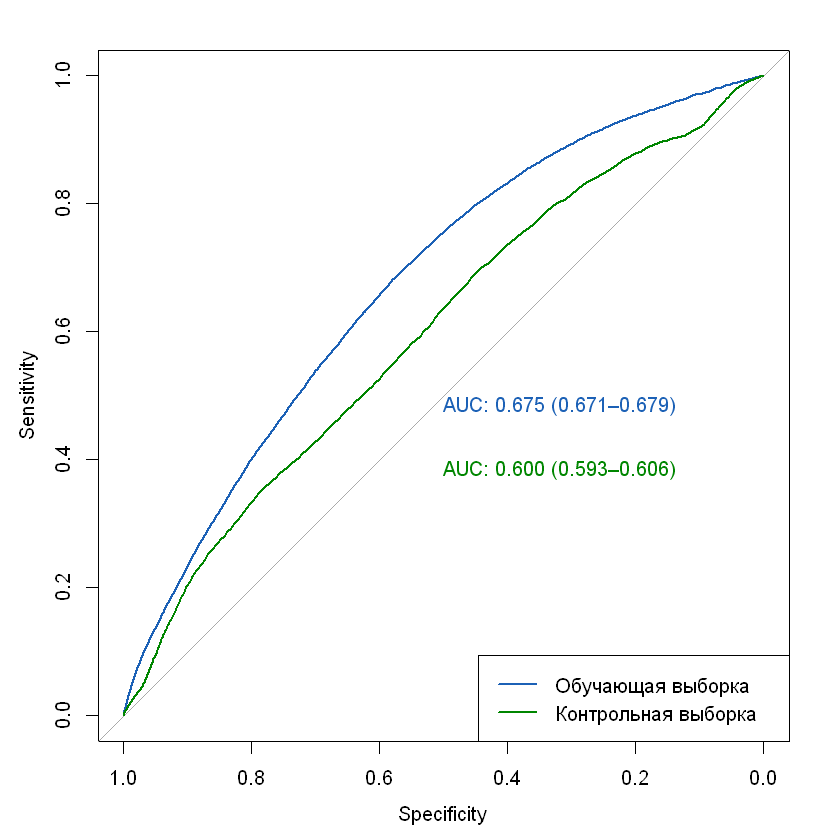

In [35]:
# удаляем служебную колонку
copy_dev2$binned <- NULL
copy_hold2$binned <- NULL

# выполняем биннинг с учетом полученных правил разбиения
copy_dev2$age <- cut(x=copy_dev2$age, 
                        breaks=c(18, 25, 28, 31, 34, 38, 43, 50, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

copy_hold2$age <- cut(x=copy_hold2$age, 
                        breaks=c(18, 25, 28, 31, 34, 38, 43, 50, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

library(randomForest)
library(doParallel)
CPUS=20; NTREE=800
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf1 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev2, importance=FALSE, ntree=ntree, mtry=2, 
               classwt=c(0.60, 0.4))
}
stopCluster(cl)

# Вычисление вероятностей классов
prob <- predict(rf1, type="prob")
prob2 <- predict(rf1, copy_hold2, type="prob")

# Строим ROC-кривые.
library(pROC)
roc_dev<-plot(roc(copy_dev2$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold2$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

credit_sum

In [36]:
copy_dev2$binned <- quantileCut(x=copy_dev2$credit_sum, n=10, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

copy_hold2$binned <- quantileCut(x=copy_hold2$credit_sum, n=10, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

# смотрим распределение значений
# переменной binned
print(summary(copy_dev2$binned))
print(summary(copy_hold2$binned))

[2.8e+03,1.1e+04] (1.1e+04,1.4e+04] (1.4e+04,1.6e+04] (1.6e+04,1.8e+04] 
            11880             11866             11868             11871 
(1.8e+04,2.1e+04] (2.1e+04,2.5e+04] (2.5e+04,2.9e+04] (2.9e+04,3.8e+04] 
            11881             11881             11852             11870 
(3.8e+04,5.1e+04]   (5.1e+04,2e+05] 
            11879             11863 
[2.5e+03,1.1e+04] (1.1e+04,1.4e+04] (1.4e+04,1.6e+04] (1.6e+04,1.8e+04] 
             5113              5064              5091              5090 
(1.8e+04,2.1e+04] (2.1e+04,2.5e+04] (2.5e+04,2.9e+04] (2.9e+04,3.7e+04] 
             5088              5084              5090              5087 
(3.7e+04,5.1e+04]   (5.1e+04,2e+05] 
             5088              5089 


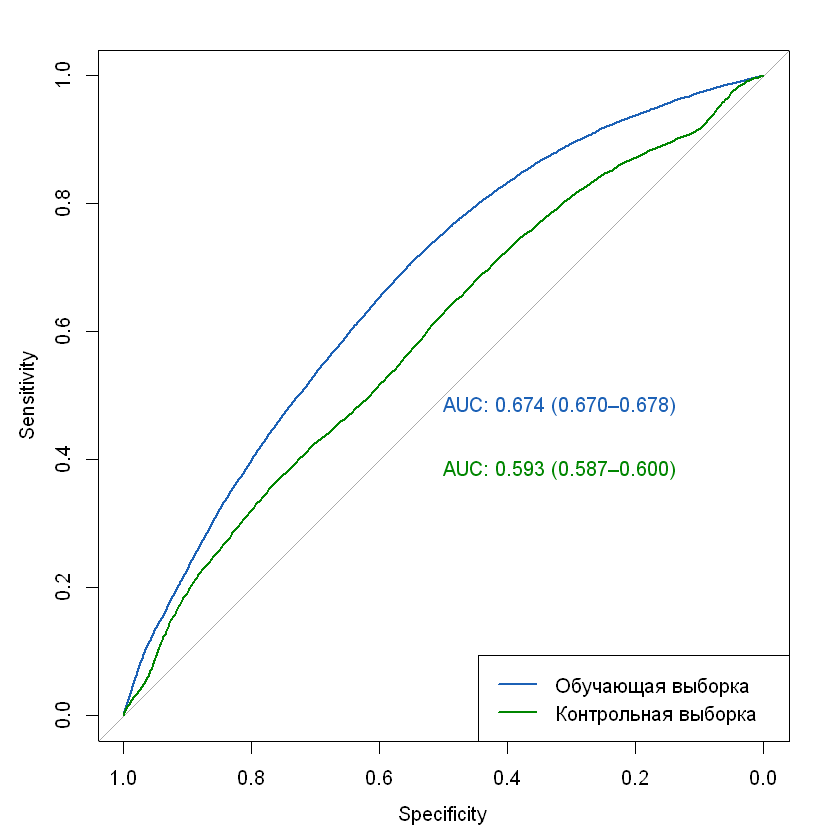

In [37]:
# удаляем служебную колонку
copy_dev2$binned <- NULL
copy_hold2$binned <- NULL

# выполняем биннинг с учетом полученных правил разбиения
copy_dev2$credit_sum <- cut(x=copy_dev2$credit_sum, 
                        breaks=c(-Inf, 11000, 14000, 16000, 18000, 21000, 25000, 29000, 38000, 50000, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

copy_hold2$credit_sum <- cut(x=copy_hold2$credit_sum, 
                        breaks=c(-Inf, 11000, 14000, 16000, 18000, 21000, 25000, 29000, 38000, 50000, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

library(randomForest)
library(doParallel)
CPUS=20; NTREE=800
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf1 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev2, importance=FALSE, ntree=ntree, mtry=2, 
               classwt=c(0.60, 0.4))
}
stopCluster(cl)

# Вычисление вероятностей классов
prob <- predict(rf1, type="prob")
prob2 <- predict(rf1, copy_hold2, type="prob")

# Строим ROC-кривые.
library(pROC)
roc_dev<-plot(roc(copy_dev2$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold2$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

monthly_income 

In [39]:
copy_dev2 <- copy_dev
copy_hold2 <- copy_hold

copy_dev2$binned <- quantileCut(x=copy_dev2$monthly_income, n=7, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

copy_hold2$binned <- quantileCut(x=copy_hold2$monthly_income, n=7, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

# смотрим распределение значений
# переменной binned
print(summary(copy_dev2$binned))
print(summary(copy_hold2$binned))

  [4.1e+03,2e+04]   (2e+04,2.5e+04]   (2.5e+04,3e+04]   (3e+04,3.9e+04] 
            18836             15567             17835             15937 
(3.9e+04,4.5e+04]   (4.5e+04,6e+04]   (6e+04,9.5e+05] 
            17329             19167             14040 
  [4.1e+03,2e+04]   (2e+04,2.5e+04]   (2.5e+04,3e+04]   (3e+04,3.8e+04] 
             8160              6520              7732              6699 
(3.8e+04,4.5e+04]   (4.5e+04,6e+04]     (6e+04,9e+05] 
             7584              8099              6090 


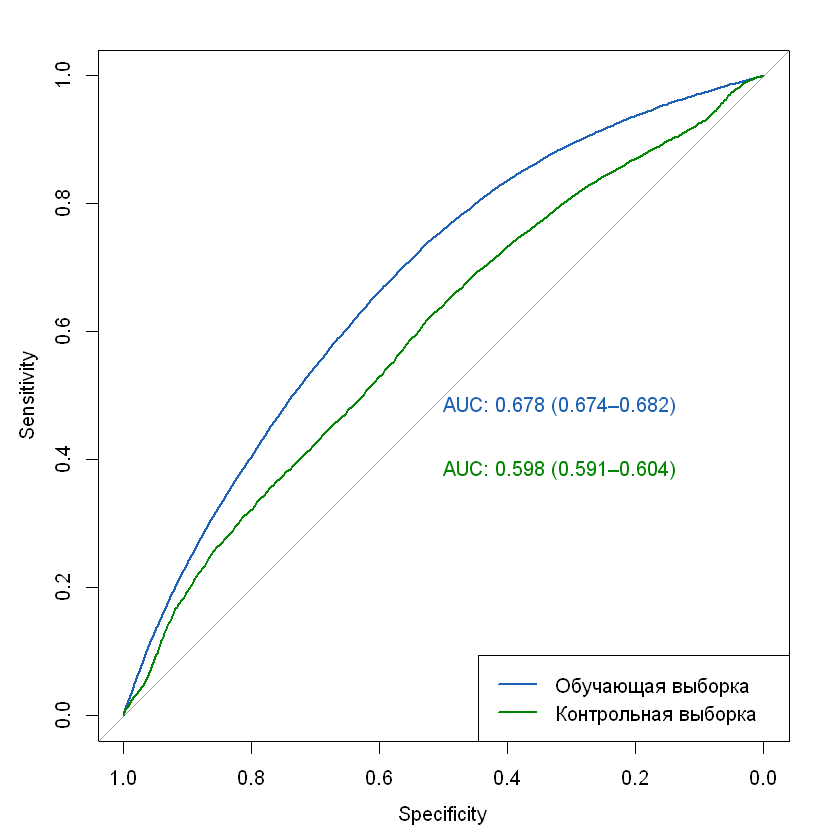

In [40]:
# удаляем служебную колонку
copy_dev2$binned <- NULL
copy_hold2$binned <- NULL

# выполняем биннинг с учетом полученных правил разбиения
copy_dev2$monthly_income <- cut(x=copy_dev2$monthly_income, 
                        breaks=c(-Inf, 20000, 25000, 30000, 39000, 45000, 60000, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

copy_hold2$monthly_income <- cut(x=copy_hold2$monthly_income, 
                        breaks=c(-Inf, 20000, 25000, 30000, 39000, 45000, 60000, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)
library(randomForest)
library(doParallel)
CPUS=20; NTREE=800
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf1 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev2, importance=FALSE, ntree=ntree, mtry=2, 
               classwt=c(0.60, 0.4))
}
stopCluster(cl)

# Вычисление вероятностей классов
prob <- predict(rf1, type="prob")
prob2 <- predict(rf1, copy_hold2, type="prob")

# Строим ROC-кривые.
library(pROC)
roc_dev<-plot(roc(copy_dev2$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold2$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

credit_month

In [41]:
copy_dev2 <- copy_dev
copy_hold2 <- copy_hold

copy_dev2$binned <- quantileCut(x=copy_dev2$credit_month, n=3, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

copy_hold2$binned <- quantileCut(x=copy_hold2$credit_month, n=3, 
                                   include.lowest=TRUE, right=TRUE, 
                                   ordered_result=TRUE, dig.lab=0)

# смотрим распределение значений
# переменной binned
print(summary(copy_dev2$binned))
print(summary(copy_hold2$binned))

 [3,10] (10,12] (12,36] 
  77087   31909    9715 
 [3,10] (10,12] (12,36] 
  33106   13712    4066 


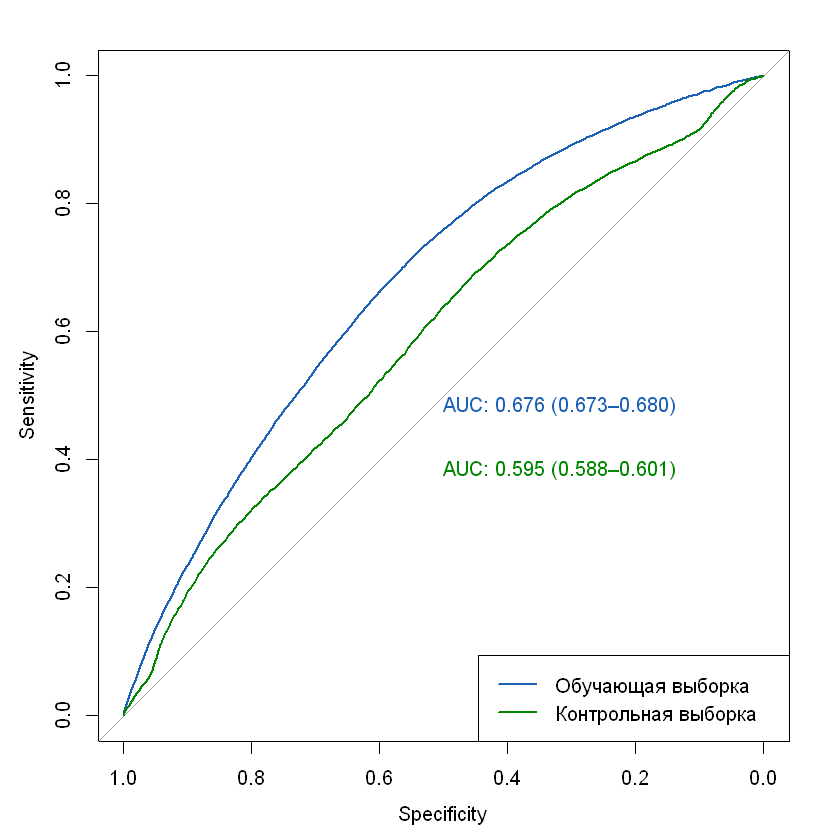

In [42]:
# удаляем служебную колонку
copy_dev2$binned <- NULL
copy_hold2$binned <- NULL

# выполняем биннинг с учетом полученных правил разбиения
copy_dev2$credit_month <- cut(x=copy_dev2$credit_month, 
                        breaks=c(0, 10, 12, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

copy_hold2$credit_month <- cut(x=copy_hold2$credit_month, 
                        breaks=c(0, 10, 12, +Inf), 
                        include.lowest=TRUE, 
                        ordered_result=TRUE)

library(randomForest)
library(doParallel)
CPUS=20; NTREE=800
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf1 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev2, importance=FALSE, ntree=ntree, mtry=2, 
               classwt=c(0.60, 0.4))
}
stopCluster(cl)

# Вычисление вероятностей классов
prob <- predict(rf1, type="prob")
prob2 <- predict(rf1, copy_hold2, type="prob")

# Строим ROC-кривые.
library(pROC)
roc_dev<-plot(roc(copy_dev2$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold2$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)

tariff_id

In [43]:
copy_dev2 <- copy_dev
copy_hold2 <- copy_hold

# Смотрим частоту по уникальным значениям
un_values <- unique(copy_dev2$tariff_id, incomparables = FALSE)
for (x in un_values){
  print(paste(x, ':', nrow(copy_dev2[copy_dev2$tariff_id == x, ])))
}

[1] "28 : 27253"
[1] "2 : 48218"
[1] "25 : 5191"
[1] "1 : 1552"
[1] "19 : 10832"
[1] "20 : 7571"
[1] "29 : 704"
[1] "18 : 2313"
[1] "3 : 2234"
[1] "30 : 3886"
[1] "10 : 273"
[1] "11 : 259"
[1] "22 : 2768"
[1] "6 : 1455"
[1] "8 : 506"
[1] "9 : 394"
[1] "12 : 205"
[1] "7 : 360"
[1] "21 : 95"
[1] "4 : 487"
[1] "32 : 300"
[1] "23 : 1545"
[1] "31 : 209"
[1] "24 : 4"
[1] "26 : 5"
[1] "5 : 26"
[1] "14 : 8"
[1] "15 : 3"
[1] "13 : 42"
[1] "16 : 9"
[1] "33 : 1"
[1] "27 : 2"
[1] "17 : 1"


Loading required package: MASS

Attaching package: 'memisc'

The following object is masked from 'package:foreach':

    foreach

The following objects are masked from 'package:stats':

    contr.sum, contr.treatment, contrasts

The following object is masked from 'package:base':

    as.array



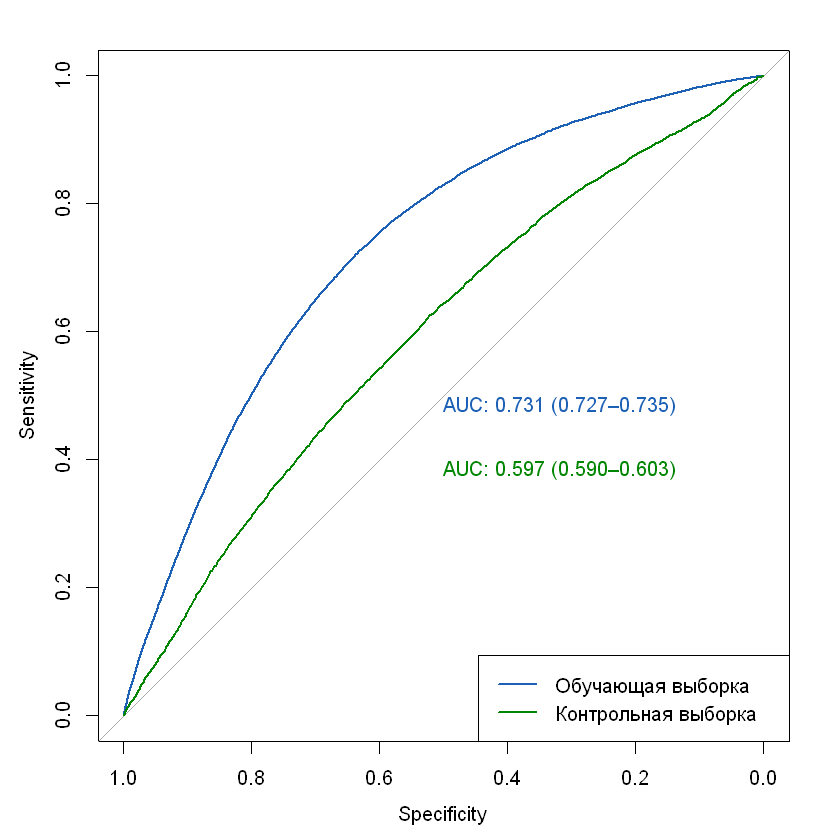

In [45]:
library(memisc)
# Укрупняем по группам, чтобы уравновесить редкие категории
copy_dev2$tariff_id <- recode(copy_dev2$tariff_id,
                            "2" <- c("2"),
                            "28" <- c("28"),
                            "19" <- c("19"),
                            "20" <- c("20"),
                            "25" <- c("25"),
                            "30_22" <- c("30", "22"),
                            "18_3_1" <- c("18", "3", "1"),
                            otherwise="OTHER")

copy_hold2$tariff_id <- recode(copy_hold2$tariff_id,
                            "2" <- c("2"),
                            "28" <- c("28"),
                            "19" <- c("19"),
                            "20" <- c("20"),
                            "25" <- c("25"),
                            "30_22" <- c("30", "22"),
                            "18_3_1" <- c("18", "3", "1"),
                            otherwise="OTHER")
copy_dev2$tariff_id <- as.factor(copy_dev2$tariff_id)
copy_hold2$tariff_id <- as.factor(copy_hold2$tariff_id)
detach("package:memisc", unload=TRUE)

library(randomForest)
library(doParallel)
CPUS=20; NTREE=800
cl = makeCluster(CPUS)
registerDoParallel(cl)

set.seed(152)
rf1 <- foreach(ntree=rep(NTREE/CPUS, CPUS), .combine=combine, .multicombine=TRUE, 
                   .packages='randomForest') %dopar% {
  randomForest(open_account_flg~., data=copy_dev2, importance=FALSE, ntree=ntree, mtry=2, 
               classwt=c(0.60, 0.4))
}
stopCluster(cl)

# Вычисление вероятностей классов
prob <- predict(rf1, type="prob")
prob2 <- predict(rf1, copy_hold2, type="prob")

# Строим ROC-кривые.
library(pROC)
roc_dev<-plot(roc(copy_dev2$open_account_flg, prob[,2], ci=TRUE), percent=TRUE, 
              print.auc=TRUE, col="#1c61b6")
roc_hold<-plot(roc(copy_hold2$open_account_flg, prob2[,2], ci=TRUE), percent=TRUE, 
               print.auc=TRUE, col="#008600", print.auc.y= .4, add=TRUE)

# Создаем легенды к ROC-кривым.
legend("bottomright", legend=c("Обучающая выборка", "Контрольная выборка"), 
       col=c("#1c61b6", "#008600"), lwd=2)